In [1]:
#!pip install segmentation-models

In [1]:
import tensorflow as tf
import tifffile
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from sklearn.model_selection import train_test_split

import sys
import os
import datetime

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
from skimage.measure import block_reduce
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [3]:
# only allocate what is needed (using for gpu memory testing)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [13]:
import matplotlib.patches as patches

def plot_image_with_patches(image, px, py, sx, sy):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')

    r, c = image.shape
    for x in range(0, r, sx):
        for y in range(0, c, sy):
            rect = patches.Rectangle((y, x), px, py, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    #plt.show()
    
def reconstruct_from_patches(patches, img_shape, patch_size, stride):
    '''stride must be either equal to patch shape or a exact factor of it'''
    # Prepare an empty array to hold the accumulated patches
    img_reconstructed = np.zeros(img_shape, dtype=np.float32)
    counts = np.zeros(img_shape, dtype=np.float32)

    # Prepare indices for extracting patches
    idx_x = np.arange(0, img_shape[1]-patch_size[1]+1, stride[1])
    idx_y = np.arange(0, img_shape[2]-patch_size[2]+1, stride[2])
    i = 0
    for x in idx_x:
        for y in idx_y:
            patch = patches[0,i // len(idx_y), i % len(idx_y),:].numpy().reshape(patch_size)
            img_reconstructed[0, x:x+patch_size[1], y:y+patch_size[2], :] += patch[0]
            counts[0, x:x+patch_size[1], y:y+patch_size[2], :] += 1
            i += 1

    # Normalize by the counts
    img_reconstructed /= counts

    return img_reconstructed


def check_mask(mask,frac,prob):
    if np.sum(mask)>mask.shape[0]*mask.shape[1]*frac:
        return 1
    elif np.random.uniform(0,1)<prob:
        return 1
    else:
        return 0
    
def check_mask_exclude_neg(mask,frac,prob):
    if mask[0,0] == -1:
        return 0
    elif np.sum(mask)>mask.shape[0]*mask.shape[1]*frac:
        return 1
    elif np.random.uniform(0,1)<prob:
        return 1
    else:
        return 0

## part2: load superstack (skip to part3 if already have single channel stacks)

In [5]:
folder_path = 'soph_annot_multiDS_7_25_23'

name = '5_24'
ds_name = name
super_file_name = 'super_stack{}.tiff'.format(name)
img_stack = tifffile.imread(os.path.join(folder_path,super_file_name))


bf_stack = np.squeeze(img_stack[:, 0, :, :]).astype(np.float32)
gutmask_stack = np.squeeze(img_stack[:, 5, :, :]).astype(np.float32)


plot_image_with_patches(bf_stack[3],256,256,128,128)

## Extracting patches

mask patches: (19, 15, 15, 65536)
im patches: (19, 15, 15, 65536)


TensorShape([19, 15, 15, 65536])

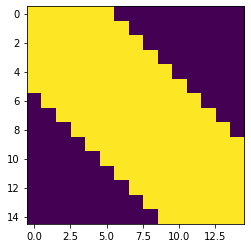

In [8]:
py = 256
px = 256
sy = 128
sx = 128


im_patches = tf.image.extract_patches(images=bf_stack[...,np.newaxis],
                           sizes=[1, py, px, 1],
                           strides=[1,sy, sy, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

mask_patches = tf.image.extract_patches(images=gutmask_stack[...,np.newaxis],
                           sizes=[1, py, px, 1],
                           strides=[1,sy, sx, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

print('mask patches:',mask_patches.shape)
print('im patches:',im_patches.shape)
p_shape = im_patches.shape

block = np.ones((p_shape[1],p_shape[2]),dtype = np.float32)
triangle_size = 5
for i in range(block.shape[0]):
    for j in range(block.shape[1]):
        # Replace the pixels of the upper right triangle with the ones from the lower left triangle
        if j > i+triangle_size or i > j+triangle_size:
            block[i,j] = 0     #block[block.shape[0]-1-i,block.shape[1]-1-j]

block_exp = np.expand_dims(np.expand_dims(block,-1),0)
block_exp.shape
plt.imshow(block)

neg_im_patches = (im_patches+1)*block_exp-1 # unwanted patches will be all -1s
neg_mask_patches = (mask_patches+1)*block_exp-1 # unwanted masks will be all -1

neg_im_patches.shape


unpatch_im = reconstruct_from_patches(neg_im_patches[:1,...],(1,2048,2048,1),(1,py,px,1),(1,sy,sx,1))
unpatch_mask = reconstruct_from_patches(neg_mask_patches[:1,...],(1,2048,2048,1),(1,py,px,1),(1,sy,sx,1))

print(unpatch_im.shape)
plt.subplot(1,2,1)
plt.imshow(unpatch_im[0,...,0])
plt.subplot(1,2,2)
plt.imshow(unpatch_mask[0,...,0])
print('unwanted patches have -1 value')

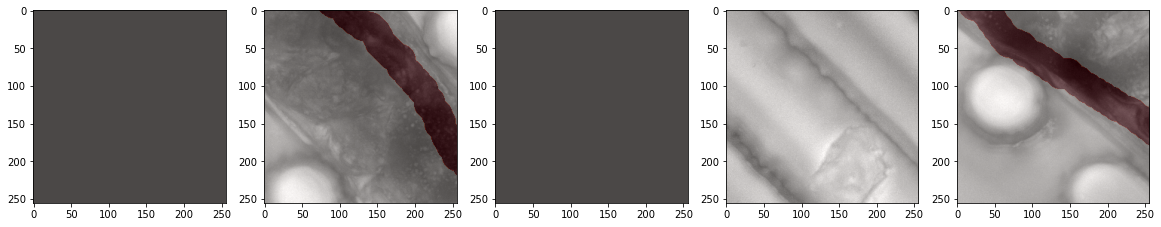

In [12]:
mask_patches_reshaped = np.array(tf.reshape(neg_mask_patches, [-1, py, px]))
mask_patches_reshaped.shape

im_patches_reshaped = np.array(tf.reshape(neg_im_patches, [-1, py, px]))
im_patches_reshaped.shape

fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    # show grayscale images

    ri = np.random.randint(0,1470)
    axs[i].imshow(im_patches_reshaped[ri,...], cmap='gray')

    axs[i].imshow(mask_patches_reshaped[ri,...], cmap='Reds', alpha=0.3)
    #axs[i].axis('off')  # hide the axes

plt.show()

fraction accepted:  0.3225730994152047
(1379, 256, 256) float32
(1379, 256, 256) float32


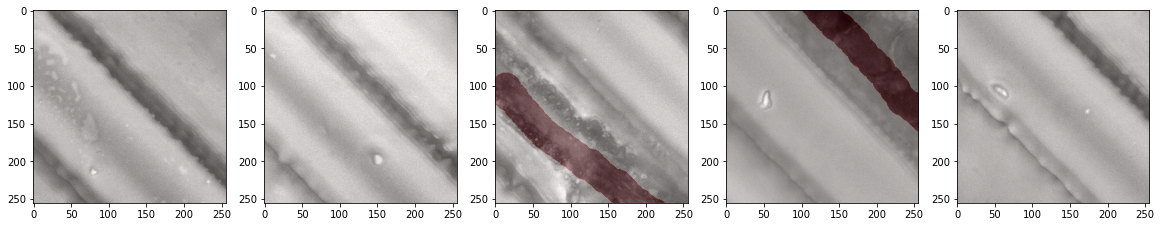

In [16]:
frac = 0 # fraction of mask pixels needed to definitely include
prob = 0.15 # fraction of patches with no/low mask pixels to include anyway

accepted_masks = [check_mask_exclude_neg(m,frac,prob) for m in mask_patches_reshaped]
print('fraction accepted: ', sum(accepted_masks)/mask_patches_reshaped.shape[0])

mask_patches_sub = np.array([m for i,m in enumerate(mask_patches_reshaped) if accepted_masks[i]==1])
img_patches_sub = np.array([m for i,m in enumerate(im_patches_reshaped) if accepted_masks[i]==1])

print(mask_patches_sub.shape,mask_patches_sub.dtype)
print(img_patches_sub.shape,img_patches_sub.dtype)


fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    # show grayscale images

    ri = np.random.randint(0,1470)
    axs[i].imshow(img_patches_sub[ri,...], cmap='gray')

    axs[i].imshow(mask_patches_sub[ri,...], cmap='Reds', alpha=0.3)
    #axs[i].axis('off')  # hide the axes

plt.show()

In [18]:
output_file = os.path.join(folder_path, 'bf_patches_256_noNorm_subsel_set5_{}.tiff'.format(ds_name))
tifffile.imsave(output_file, img_patches_sub)

output_file = os.path.join(folder_path, 'mask_patches_256_noNorm_subsel_set5_{}.tiff'.format(ds_name))
tifffile.imsave(output_file, mask_patches_sub)

## ds 2

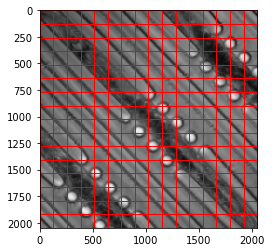

In [19]:
folder_path = 'soph_annot_multiDS_7_25_23'

name = '6_4'
ds_name = name
super_file_name = 'super_stack{}.tiff'.format(name)
img_stack = tifffile.imread(os.path.join(folder_path,super_file_name))


bf_stack = np.squeeze(img_stack[:, 0, :, :]).astype(np.float32)
gutmask_stack = np.squeeze(img_stack[:, 5, :, :]).astype(np.float32)


plot_image_with_patches(bf_stack[3],256,256,128,128)

## Extracting patches

mask patches: (14, 15, 15, 65536)
im patches: (14, 15, 15, 65536)
(1, 2048, 2048, 1)
unwanted patches have -1 value


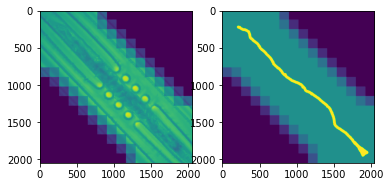

In [20]:
py = 256
px = 256
sy = 128
sx = 128


im_patches = tf.image.extract_patches(images=bf_stack[...,np.newaxis],
                           sizes=[1, py, px, 1],
                           strides=[1,sy, sy, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

mask_patches = tf.image.extract_patches(images=gutmask_stack[...,np.newaxis],
                           sizes=[1, py, px, 1],
                           strides=[1,sy, sx, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

print('mask patches:',mask_patches.shape)
print('im patches:',im_patches.shape)
p_shape = im_patches.shape

block = np.ones((p_shape[1],p_shape[2]),dtype = np.float32)
triangle_size = 5
for i in range(block.shape[0]):
    for j in range(block.shape[1]):
        # Replace the pixels of the upper right triangle with the ones from the lower left triangle
        if j > i+triangle_size or i > j+triangle_size:
            block[i,j] = 0     #block[block.shape[0]-1-i,block.shape[1]-1-j]

block_exp = np.expand_dims(np.expand_dims(block,-1),0)
block_exp.shape
plt.imshow(block)

neg_im_patches = (im_patches+1)*block_exp-1 # unwanted patches will be all -1s
neg_mask_patches = (mask_patches+1)*block_exp-1 # unwanted masks will be all -1

neg_im_patches.shape


unpatch_im = reconstruct_from_patches(neg_im_patches[:1,...],(1,2048,2048,1),(1,py,px,1),(1,sy,sx,1))
unpatch_mask = reconstruct_from_patches(neg_mask_patches[:1,...],(1,2048,2048,1),(1,py,px,1),(1,sy,sx,1))

print(unpatch_im.shape)
plt.subplot(1,2,1)
plt.imshow(unpatch_im[0,...,0])
plt.subplot(1,2,2)
plt.imshow(unpatch_mask[0,...,0])
print('unwanted patches have -1 value')

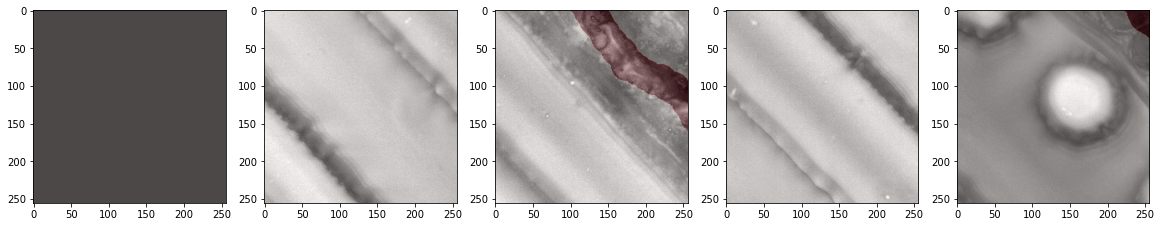

In [21]:
mask_patches_reshaped = np.array(tf.reshape(neg_mask_patches, [-1, py, px]))
mask_patches_reshaped.shape

im_patches_reshaped = np.array(tf.reshape(neg_im_patches, [-1, py, px]))
im_patches_reshaped.shape

fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    # show grayscale images

    ri = np.random.randint(0,1470)
    axs[i].imshow(im_patches_reshaped[ri,...], cmap='gray')

    axs[i].imshow(mask_patches_reshaped[ri,...], cmap='Reds', alpha=0.3)
    #axs[i].axis('off')  # hide the axes

plt.show()

fraction accepted:  0.3146031746031746
(991, 256, 256) float32
(991, 256, 256) float32


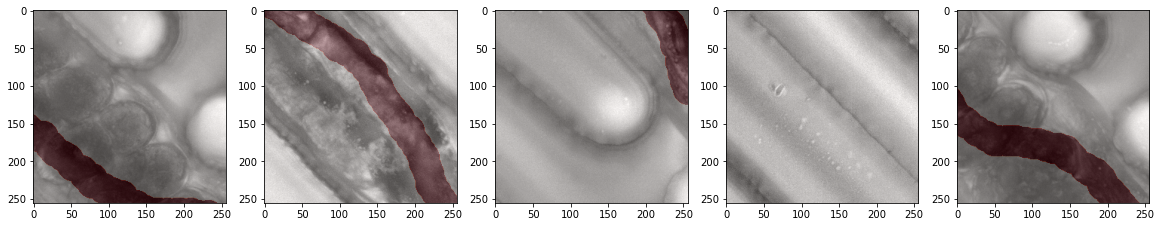

In [23]:
frac = 0 # fraction of mask pixels needed to definitely include
prob = 0.15 # fraction of patches with no/low mask pixels to include anyway

accepted_masks = [check_mask_exclude_neg(m,frac,prob) for m in mask_patches_reshaped]
print('fraction accepted: ', sum(accepted_masks)/mask_patches_reshaped.shape[0])

mask_patches_sub = np.array([m for i,m in enumerate(mask_patches_reshaped) if accepted_masks[i]==1])
img_patches_sub = np.array([m for i,m in enumerate(im_patches_reshaped) if accepted_masks[i]==1])

print(mask_patches_sub.shape,mask_patches_sub.dtype)
print(img_patches_sub.shape,img_patches_sub.dtype)


fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    # show grayscale images

    ri = np.random.randint(0,len(img_patches_sub))
    axs[i].imshow(img_patches_sub[ri,...], cmap='gray')

    axs[i].imshow(mask_patches_sub[ri,...], cmap='Reds', alpha=0.3)
    #axs[i].axis('off')  # hide the axes

plt.show()

In [24]:
output_file = os.path.join(folder_path, 'bf_patches_256_noNorm_subsel_set5_{}.tiff'.format(ds_name))
tifffile.imsave(output_file, img_patches_sub)

output_file = os.path.join(folder_path, 'mask_patches_256_noNorm_subsel_set5_{}.tiff'.format(ds_name))
tifffile.imsave(output_file, mask_patches_sub)

## ds 3 6_6

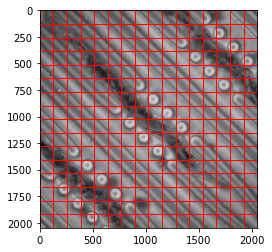

In [25]:
folder_path = 'soph_annot_multiDS_7_25_23'

name = '6_6'
ds_name = name
super_file_name = 'super_stack{}.tiff'.format(name)
img_stack = tifffile.imread(os.path.join(folder_path,super_file_name))


bf_stack = np.squeeze(img_stack[:, 0, :, :]).astype(np.float32)
gutmask_stack = np.squeeze(img_stack[:, 5, :, :]).astype(np.float32)


plot_image_with_patches(bf_stack[3],256,256,128,128)

mask patches: (20, 15, 15, 65536)
im patches: (20, 15, 15, 65536)
(1, 2048, 2048, 1)
unwanted patches have -1 value


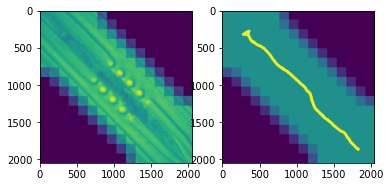

In [26]:
py = 256
px = 256
sy = 128
sx = 128


im_patches = tf.image.extract_patches(images=bf_stack[...,np.newaxis],
                           sizes=[1, py, px, 1],
                           strides=[1,sy, sy, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

mask_patches = tf.image.extract_patches(images=gutmask_stack[...,np.newaxis],
                           sizes=[1, py, px, 1],
                           strides=[1,sy, sx, 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

print('mask patches:',mask_patches.shape)
print('im patches:',im_patches.shape)
p_shape = im_patches.shape

block = np.ones((p_shape[1],p_shape[2]),dtype = np.float32)
triangle_size = 5
for i in range(block.shape[0]):
    for j in range(block.shape[1]):
        # Replace the pixels of the upper right triangle with the ones from the lower left triangle
        if j > i+triangle_size or i > j+triangle_size:
            block[i,j] = 0     #block[block.shape[0]-1-i,block.shape[1]-1-j]

block_exp = np.expand_dims(np.expand_dims(block,-1),0)
block_exp.shape
plt.imshow(block)

neg_im_patches = (im_patches+1)*block_exp-1 # unwanted patches will be all -1s
neg_mask_patches = (mask_patches+1)*block_exp-1 # unwanted masks will be all -1

neg_im_patches.shape


unpatch_im = reconstruct_from_patches(neg_im_patches[:1,...],(1,2048,2048,1),(1,py,px,1),(1,sy,sx,1))
unpatch_mask = reconstruct_from_patches(neg_mask_patches[:1,...],(1,2048,2048,1),(1,py,px,1),(1,sy,sx,1))

print(unpatch_im.shape)
plt.subplot(1,2,1)
plt.imshow(unpatch_im[0,...,0])
plt.subplot(1,2,2)
plt.imshow(unpatch_mask[0,...,0])
print('unwanted patches have -1 value')

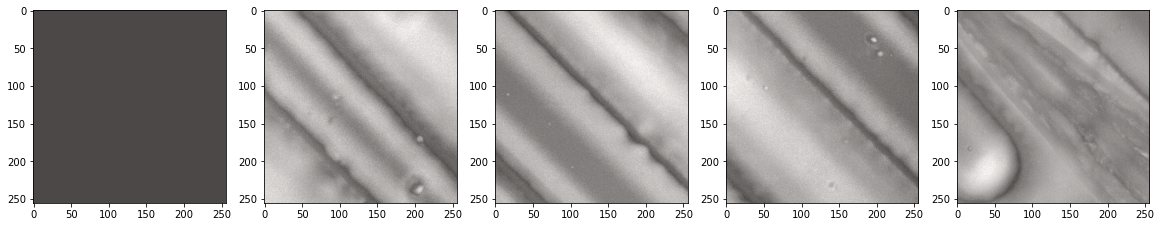

In [27]:
mask_patches_reshaped = np.array(tf.reshape(neg_mask_patches, [-1, py, px]))
mask_patches_reshaped.shape

im_patches_reshaped = np.array(tf.reshape(neg_im_patches, [-1, py, px]))
im_patches_reshaped.shape

fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    # show grayscale images

    ri = np.random.randint(0,1470)
    axs[i].imshow(im_patches_reshaped[ri,...], cmap='gray')

    axs[i].imshow(mask_patches_reshaped[ri,...], cmap='Reds', alpha=0.3)
    #axs[i].axis('off')  # hide the axes

plt.show()

fraction accepted:  0.2737777777777778
(1232, 256, 256) float32
(1232, 256, 256) float32


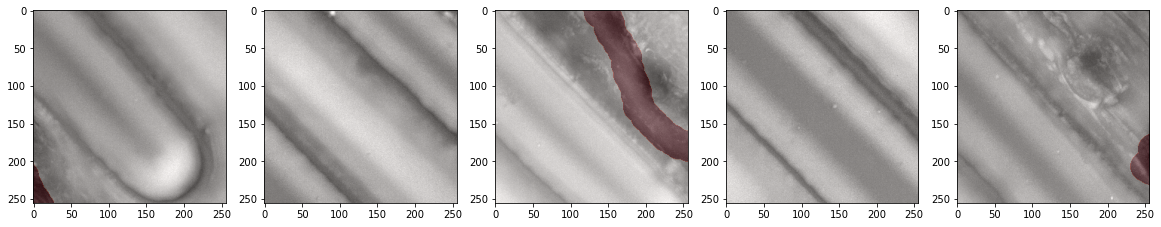

In [29]:
frac = 0 # fraction of mask pixels needed to definitely include
prob = 0.15 # fraction of patches with no/low mask pixels to include anyway

accepted_masks = [check_mask_exclude_neg(m,frac,prob) for m in mask_patches_reshaped]
print('fraction accepted: ', sum(accepted_masks)/mask_patches_reshaped.shape[0])

mask_patches_sub = np.array([m for i,m in enumerate(mask_patches_reshaped) if accepted_masks[i]==1])
img_patches_sub = np.array([m for i,m in enumerate(im_patches_reshaped) if accepted_masks[i]==1])

print(mask_patches_sub.shape,mask_patches_sub.dtype)
print(img_patches_sub.shape,img_patches_sub.dtype)


fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i in range(5):
    # show grayscale images

    ri = np.random.randint(0,len(img_patches_sub))
    axs[i].imshow(img_patches_sub[ri,...], cmap='gray')

    axs[i].imshow(mask_patches_sub[ri,...], cmap='Reds', alpha=0.3)
    #axs[i].axis('off')  # hide the axes

plt.show()

In [30]:
output_file = os.path.join(folder_path, 'bf_patches_256_noNorm_subsel_set5_{}.tiff'.format(ds_name))
tifffile.imsave(output_file, img_patches_sub)

output_file = os.path.join(folder_path, 'mask_patches_256_noNorm_subsel_set5_{}.tiff'.format(ds_name))
tifffile.imsave(output_file, mask_patches_sub)